<a href="https://colab.research.google.com/github/valentindbdg/End-to-end-ML-project-using-TFX/blob/main/End_to_end_ML_project_with_TFX_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Develop an end-to-end ML project with TensorFlow Extended

##Introduction
GOAL

* Create a ML pipeline using Tensorflow Extended
* Evaluate models
* Serve models

MODEL 
* Binary classifier 

DATA
* [Census Income dataset](http://archive.ics.uci.edu/ml/datasets/Census+Income)



*COMING:*
* Tuner component to do hyperparameter tuning: https://colab.research.google.com/drive/1oh9McgDVQslZF0uIq1heeF92-OP8EDLV#scrollTo=QZkbL7sO8Y1N
* Serving with Kubernetes and horizontal scaling
* Check model fairness
* Develop new models to improve performances
* Monitor model: serving - training skew / distribution


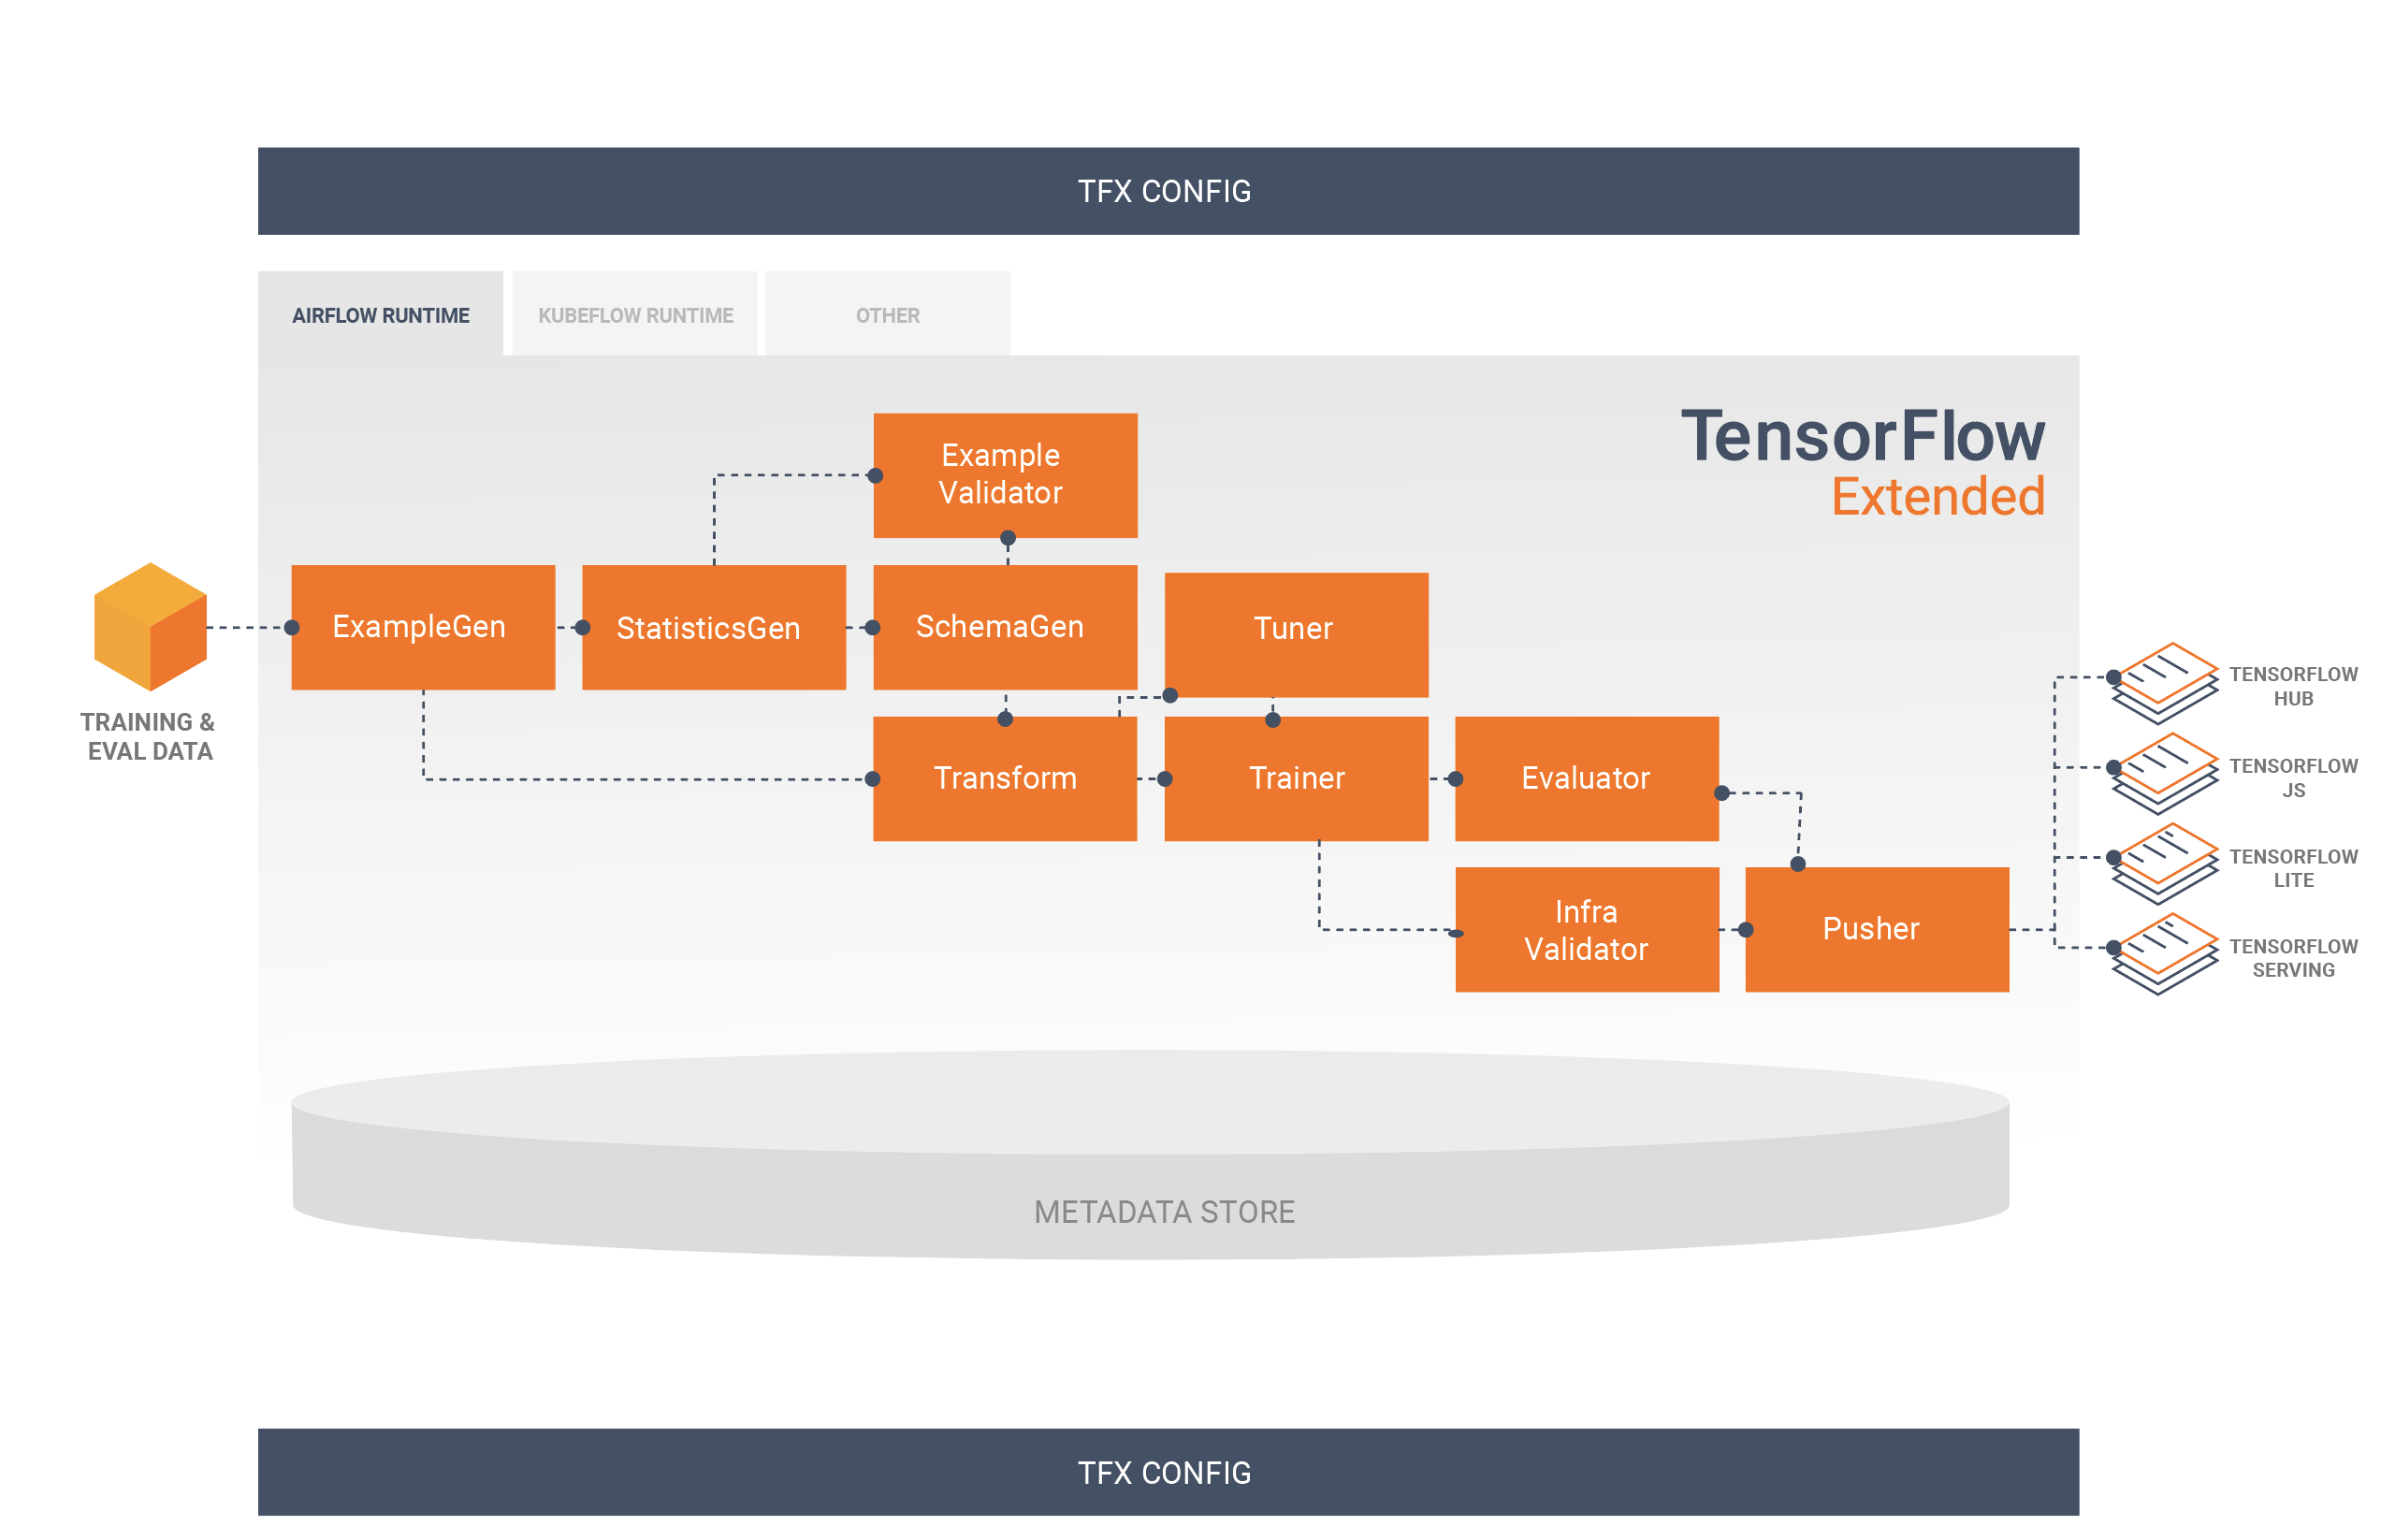

### A good ML-based solution is not only about developing the best model:
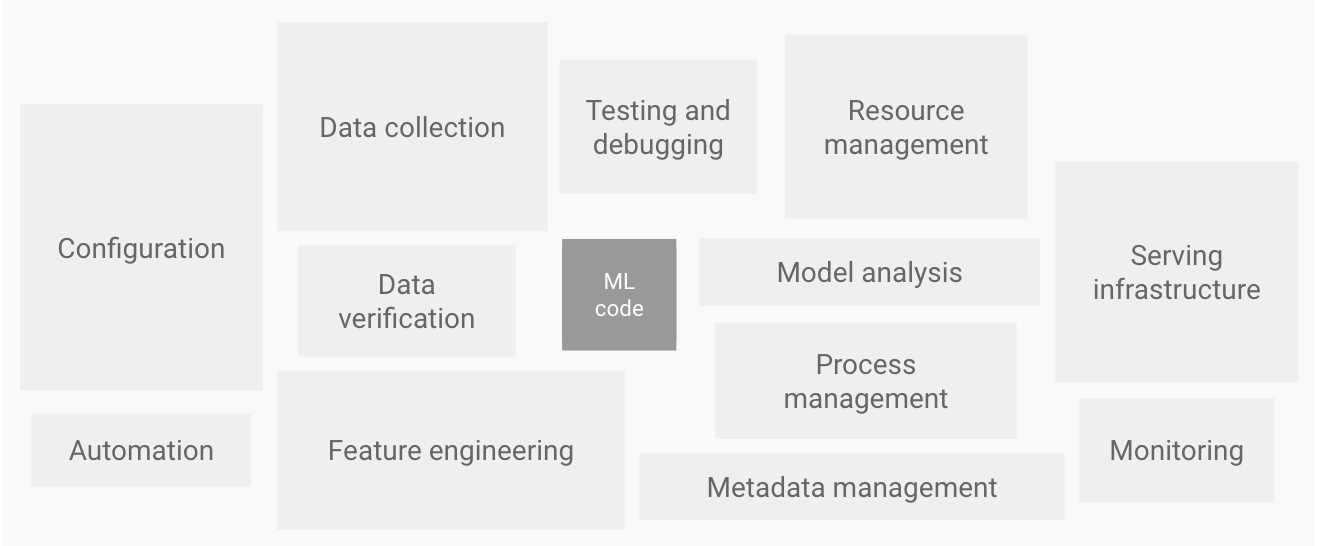

### Corresponding TFX libraries per component:
In this notebook, the following components will be used:
* ExampleGen
* StatisticsGen, SchemaGen, ExampleValidator
* Transform
* Tuner, Trainer
* [Evaluator](https://www.tensorflow.org/tfx/guide/evaluator) checks if model meets the minimum requirements and compares with previous models.
* Pusher

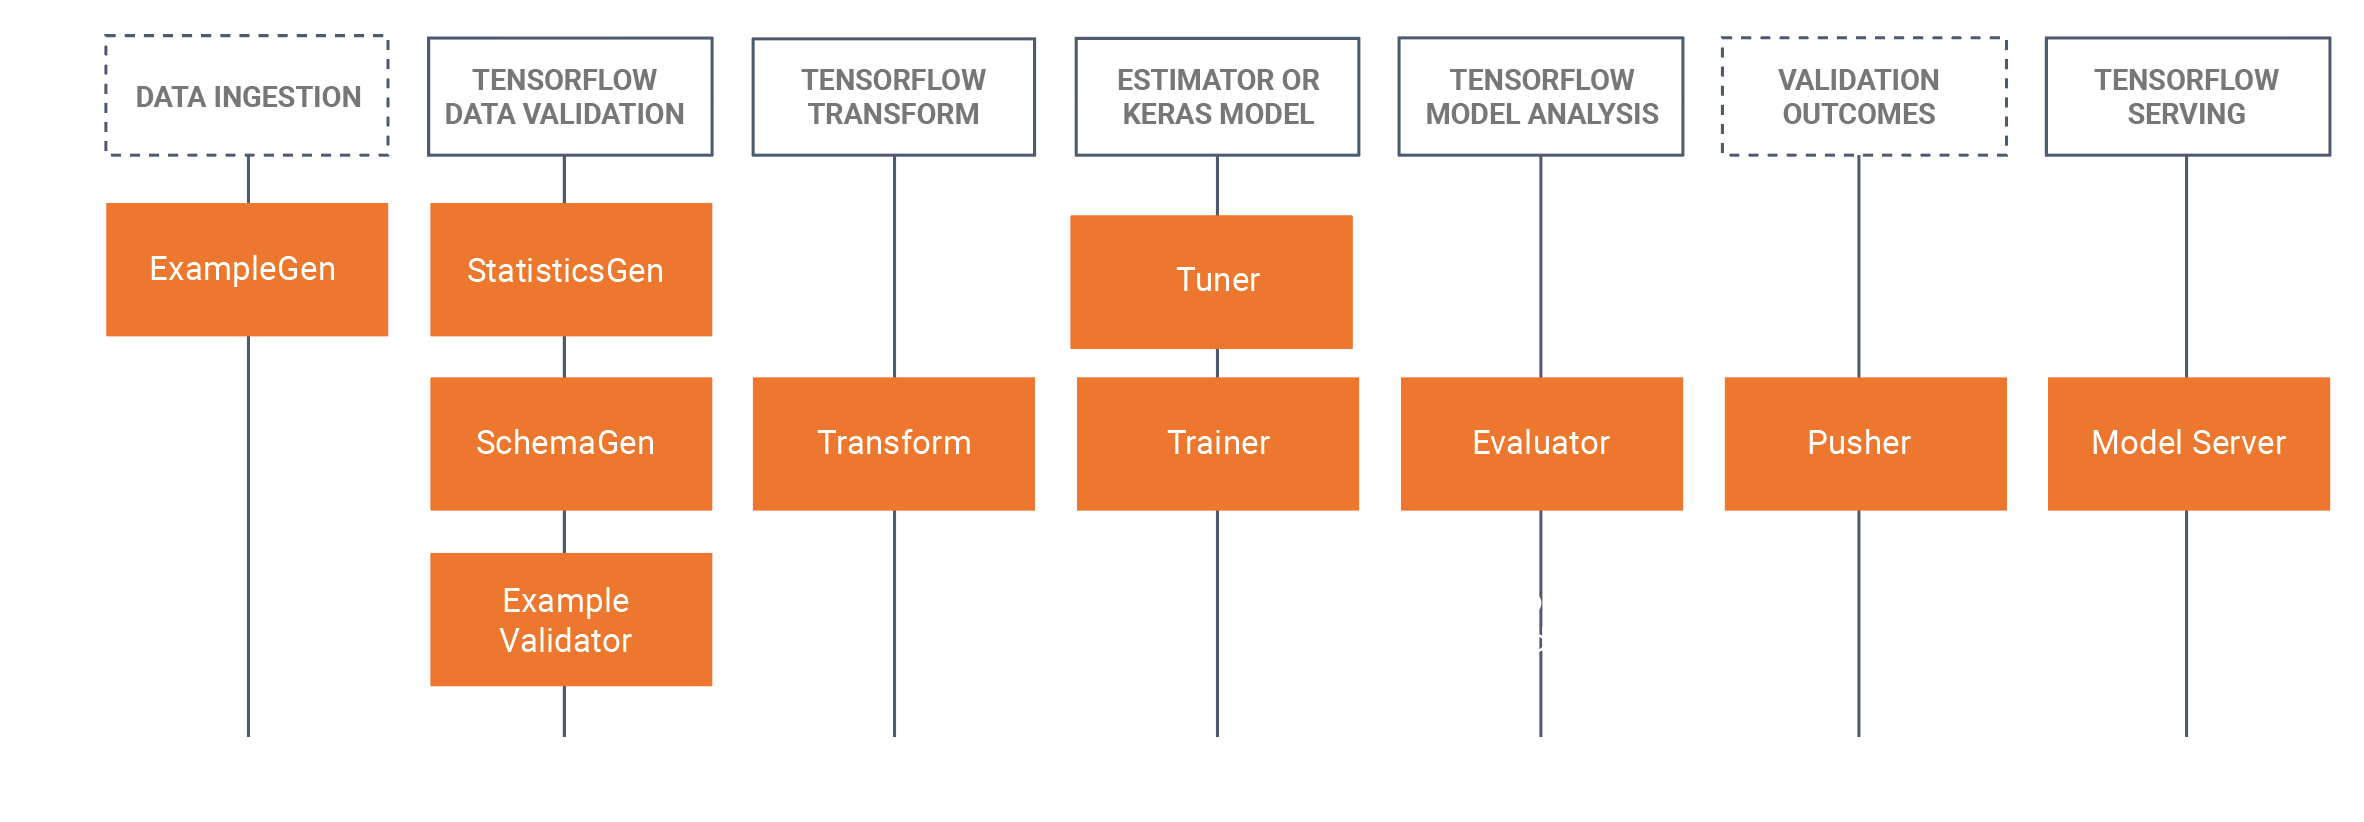

## Setup

### Install TFX

In [1]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

!pip install -U tfx

     |████████████████████████████████| 2.1 MB 7.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.6/433.6 KB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.0 MB/s eta 0:00:00


###*In Google Colab, **the runtime must be restarted**.* 

In [2]:
exit()

### Imports


In [1]:
import os
import pprint

import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))
import tensorflow_model_analysis as tfma


from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext

tf.get_logger().propagate = False
tf.get_logger().setLevel('ERROR')
pp = pprint.PrettyPrinter()

TensorFlow version: 2.8.0
TFX version: 1.7.0


### Set up pipeline paths
The main pipeline paths are set up

In [2]:
# Location of the pipeline metadata store
import os

PIPELINE_NAME = "census-pipeline"

# Output directory to store artifacts generated from the pipeline.
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)
# Path to a SQLite DB file to use as an MLMD storage.
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'metadata.db')
# Output directory where created models from the pipeline will be exported.
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)

from absl import logging
logging.set_verbosity(logging.INFO)  # Set default logging level.





import urllib.request
import tempfile

DATA_ROOT = '/content/data/census'  # Create a temporary directory.
TAR_NAME = 'C3_W4_Lab_2_data.tar.gz'
DATA_PATH = f'https://storage.googleapis.com/mlep-public/course_3/week4/{TAR_NAME}'
!wget -nc {DATA_PATH}
!tar xvzf {TAR_NAME}
!rm {TAR_NAME}

--2022-03-26 00:05:59--  https://storage.googleapis.com/mlep-public/course_3/week4/C3_W4_Lab_2_data.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.135.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418898 (409K) [application/x-gzip]
Saving to: ‘C3_W4_Lab_2_data.tar.gz’

C3_W4_Lab_2_data.ta 100%[===================>] 409.08K  --.-KB/s    in 0.003s  

2022-03-26 00:06:00 (151 MB/s) - ‘C3_W4_Lab_2_data.tar.gz’ saved [418898/418898]

./data/census/data.csv


### Download and prepare the dataset

The training split of the [Census Income Dataset](http://archive.ics.uci.edu/ml/datasets/Census+Income) is downloaded from a google drive repository [usin this method](https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99)

In [3]:
# Preview dataset
!head {_data_filepath}

head: cannot open '{_data_filepath}' for reading: No such file or directory


Convert and explore dataset with Pandas

## TFX Pipeline

### Create the InteractiveContext

The pipeline is initialized and a local SQLite file is used for the metadata store.

### Transform

Feature engineering is performed on the training data. One of the benefits of using TFX is that the transformation code is written once, and the resulting transforms will be consistent between training and serving.

The transform code:
* scales the numeric features 
* one-hot encodes the categorical variables.

*Note: Make sure that the model builder code in the `Trainer` component also reflects changes made here. Removing a feature here should also remove an input layer for that feature in the model.*



In [4]:
# Set the constants module filename
_census_constants_module_file = 'census_constants.py'

In [5]:
%%writefile {_census_constants_module_file}

# Features with string data types that will be converted to indices
VOCAB_FEATURE_DICT = {
    'education': 16, 'marital-status': 7, 'occupation': 15, 'race': 5, 
    'relationship': 6, 'workclass': 9, 'sex': 2, 'native-country': 42
}

# Numerical features that are marked as continuous
NUMERIC_FEATURE_KEYS = ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Feature that can be grouped into buckets
BUCKET_FEATURE_DICT = {'age': 4}

# Number of out-of-vocabulary buckets
NUM_OOV_BUCKETS = 5

# Feature that the model will predict
LABEL_KEY = 'label'

Writing census_constants.py


In [6]:
# Set the transform module filename
_census_transform_module_file = 'census_transform.py'

In [7]:
%%writefile {_census_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

# import constants from cells above
import census_constants

# Unpack the contents of the constants module
_NUMERIC_FEATURE_KEYS = census_constants.NUMERIC_FEATURE_KEYS
_VOCAB_FEATURE_DICT = census_constants.VOCAB_FEATURE_DICT
_BUCKET_FEATURE_DICT = census_constants.BUCKET_FEATURE_DICT
_NUM_OOV_BUCKETS = census_constants.NUM_OOV_BUCKETS
_LABEL_KEY = census_constants.LABEL_KEY

# Define the transformations
def preprocessing_fn(inputs):
    """tf.transform's callback function for preprocessing inputs.
    Args:
        inputs: map from feature keys to raw not-yet-transformed features.
    Returns:
        Map from string feature key to transformed feature operations.
    """

    # Initialize outputs dictionary
    outputs = {}

    # Scale these features to the range [0,1]
    for key in _NUMERIC_FEATURE_KEYS:
        scaled = tft.scale_to_0_1(inputs[key])
        outputs[key] = tf.reshape(scaled, [-1])

    # Convert strings to indices and convert to one-hot vectors
    for key, vocab_size in _VOCAB_FEATURE_DICT.items():
        indices = tft.compute_and_apply_vocabulary(inputs[key], num_oov_buckets=_NUM_OOV_BUCKETS)
        one_hot = tf.one_hot(indices, vocab_size + _NUM_OOV_BUCKETS)
        outputs[key] = tf.reshape(one_hot, [-1, vocab_size + _NUM_OOV_BUCKETS])

    # Bucketize this feature and convert to one-hot vectors
    for key, num_buckets in _BUCKET_FEATURE_DICT.items():
        indices = tft.bucketize(inputs[key], num_buckets)
        one_hot = tf.one_hot(indices, num_buckets)
        outputs[key] = tf.reshape(one_hot, [-1, num_buckets])

    # Cast label to float
    outputs[_LABEL_KEY] = tf.cast(inputs[_LABEL_KEY], tf.float32)

    return outputs

Writing census_transform.py


### Trainer

The model is built to make predictions: A binary classifier where the label is 
* 1 if a person earns more than 50k USD
* 0 if less than or equal. 

The model used here uses the [wide and deep model](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) as reference. 

Next step: the hyperparameters (e.g. number of hidden units) have been hardcoded but will be improved suing a `Tuner` component.

As a reminder, it is best to start from `run_fn()` when you're reviewing the module file below. The `Trainer` component looks for that function first. All other functions defined in the module are just utility functions for `run_fn()`.

Another thing you will notice below is the `_get_serve_tf_examples_fn()` function. This is tied to the `serving_default` [signature](https://www.tensorflow.org/guide/saved_model#specifying_signatures_during_export) which makes it possible for you to just pass in raw features when the model is served for inference. This is done by decorating the enclosing function, `serve_tf_examples_fn()`, with [tf.function](https://www.tensorflow.org/guide/intro_to_graphs). This indicates that the computation will be done by first tracing a [Tensorflow graph](https://www.tensorflow.org/api_docs/python/tf/Graph). You will notice that this function uses `model.tft_layer` which comes from `transform_graph` output. Now when you call the `.get_concrete_function()` method on this tf.function in `run_fn()`, you are creating the graph that will be used in later computations. This graph is used whenever you pass in an `examples` argument pointing to a Tensor with `tf.string` dtype.



In [8]:
# Declare trainer module file
_census_trainer_module_file = 'census_trainer.py'

In [9]:
%%writefile {_census_trainer_module_file}

from typing import List, Text

import tensorflow as tf
import tensorflow_transform as tft
from tensorflow_transform.tf_metadata import schema_utils

from tfx.components.trainer.fn_args_utils import DataAccessor, FnArgs
from tfx_bsl.public.tfxio import TensorFlowDatasetOptions

# import same constants from transform module
import census_constants

# Unpack the contents of the constants module
_NUMERIC_FEATURE_KEYS = census_constants.NUMERIC_FEATURE_KEYS
_VOCAB_FEATURE_DICT = census_constants.VOCAB_FEATURE_DICT
_BUCKET_FEATURE_DICT = census_constants.BUCKET_FEATURE_DICT
_NUM_OOV_BUCKETS = census_constants.NUM_OOV_BUCKETS
_LABEL_KEY = census_constants.LABEL_KEY


def _gzip_reader_fn(filenames):
  '''Load compressed dataset
  
  Args:
    filenames - filenames of TFRecords to load

  Returns:
    TFRecordDataset loaded from the filenames
  '''

  # Load the dataset. Specify the compression type since it is saved as `.gz`
  return tf.data.TFRecordDataset(filenames, compression_type='GZIP')


def _input_fn(file_pattern,
              tf_transform_output,
              num_epochs=None,
              batch_size=32) -> tf.data.Dataset:
  '''Create batches of features and labels from TF Records

  Args:
    file_pattern - List of files or patterns of file paths containing Example records.
    tf_transform_output - transform output graph
    num_epochs - Integer specifying the number of times to read through the dataset. 
            If None, cycles through the dataset forever.
    batch_size - An int representing the number of records to combine in a single batch.

  Returns:
    A dataset of dict elements, (or a tuple of dict elements and label). 
    Each dict maps feature keys to Tensor or SparseTensor objects.
  '''

  # Get post-transfrom feature spec
  transformed_feature_spec = (
      tf_transform_output.transformed_feature_spec().copy())
  
  # Create batches of data
  dataset = tf.data.experimental.make_batched_features_dataset(
      file_pattern=file_pattern,
      batch_size=batch_size,
      features=transformed_feature_spec,
      reader=_gzip_reader_fn,
      num_epochs=num_epochs,
      label_key=_LABEL_KEY
      )
  
  return dataset


def _get_serve_tf_examples_fn(model, tf_transform_output):
  """Returns a function that parses a serialized tf.Example and applies TFT."""

  # Get transformation graph
  model.tft_layer = tf_transform_output.transform_features_layer()

  @tf.function
  def serve_tf_examples_fn(serialized_tf_examples):
    """Returns the output to be used in the serving signature."""
    # Get pre-transform feature spec
    feature_spec = tf_transform_output.raw_feature_spec()

    # Pop label since serving inputs do not include the label
    feature_spec.pop(_LABEL_KEY)

    # Parse raw examples into a dictionary of tensors matching the feature spec
    parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)

    # Transform the raw examples using the transform graph
    transformed_features = model.tft_layer(parsed_features)

    # Get predictions using the transformed features
    return model(transformed_features)

  return serve_tf_examples_fn


def _build_keras_model(hidden_units: List[int] = None) -> tf.keras.Model:
  """Creates a DNN Keras model for classifying income data.

  Args:
    hidden_units: [int], the layer sizes of the DNN (input layer first).

  Returns:
    A keras Model.
  """

  # Use helper function to create the model
  model = _wide_and_deep_classifier(
      dnn_hidden_units=hidden_units or [100, 70, 50, 25])
  
  return model


def _wide_and_deep_classifier(dnn_hidden_units):
  """Build a simple keras wide and deep model using the Functional API.

  Args:
    wide_columns: Feature columns wrapped in indicator_column for wide (linear)
      part of the model.
    deep_columns: Feature columns for deep part of the model.
    dnn_hidden_units: [int], the layer sizes of the hidden DNN.

  Returns:
    A Wide and Deep Keras model
  """

  # Define input layers for numeric keys
  input_numeric = [
      tf.keras.layers.Input(name=colname, shape=(1,), dtype=tf.float32)
      for colname in _NUMERIC_FEATURE_KEYS
  ]

  # Define input layers for vocab keys
  input_categorical = [
      tf.keras.layers.Input(name=colname, shape=(vocab_size + _NUM_OOV_BUCKETS,), dtype=tf.float32)
      for colname, vocab_size in _VOCAB_FEATURE_DICT.items()
  ]

  # Define input layers for bucket key
  input_categorical += [
      tf.keras.layers.Input(name=colname, shape=(num_buckets,), dtype=tf.float32)
      for colname, num_buckets in _BUCKET_FEATURE_DICT.items()
  ]

  # Concatenate numeric inputs
  deep = tf.keras.layers.concatenate(input_numeric)

  # Create deep dense network for numeric inputs
  for numnodes in dnn_hidden_units:
    deep = tf.keras.layers.Dense(numnodes)(deep)

  # Concatenate categorical inputs
  wide = tf.keras.layers.concatenate(input_categorical)

  # Create shallow dense network for categorical inputs
  wide = tf.keras.layers.Dense(128, activation='relu')(wide)

  # Combine wide and deep networks
  combined = tf.keras.layers.concatenate([deep, wide])
                                              
  # Define output of binary classifier
  output = tf.keras.layers.Dense(
      1, activation='sigmoid')(combined)

  # Setup combined input
  input_layers = input_numeric + input_categorical

  # Create the Keras model
  model = tf.keras.Model(input_layers, output)

  # Define training parameters
  model.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.Adam(lr=0.001),
      metrics='binary_accuracy')
  
  # Print model summary
  model.summary()

  return model


# TFX Trainer will call this function.
def run_fn(fn_args: FnArgs):
  """Defines and trains the model.
  
  Args:
    fn_args: Holds args as name/value pairs. Refer here for the complete attributes: 
    https://www.tensorflow.org/tfx/api_docs/python/tfx/components/trainer/fn_args_utils/FnArgs#attributes
  """

  # Number of nodes in the first layer of the DNN
  first_dnn_layer_size = 100
  num_dnn_layers = 4
  dnn_decay_factor = 0.7

  # Get transform output (i.e. transform graph) wrapper
  tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)

  # Create batches of train and eval sets
  train_dataset = _input_fn(fn_args.train_files[0], tf_transform_output, 10)
  eval_dataset = _input_fn(fn_args.eval_files[0], tf_transform_output, 10)

  # Build the model
  model = _build_keras_model(
      # Construct layers sizes with exponential decay
      hidden_units=[
          max(2, int(first_dnn_layer_size * dnn_decay_factor**i))
          for i in range(num_dnn_layers)
      ])
  
  # Callback for TensorBoard
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=fn_args.model_run_dir, update_freq='batch')


  # Train the model
  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks=[tensorboard_callback])
  

  # Define default serving signature
  signatures = {
      'serving_default':
          _get_serve_tf_examples_fn(model,
                                    tf_transform_output).get_concrete_function(
                                        tf.TensorSpec(
                                            shape=[None],
                                            dtype=tf.string,
                                            name='examples')),
  }
  

  # Save model with signature
  model.save(fn_args.serving_model_dir, save_format='tf', signatures=signatures)

Writing census_trainer.py


## Pipeline Definition

In [10]:
import tensorflow_model_analysis as tfma

def _create_pipeline(pipeline_name: str, pipeline_root: str, data_root: str,
                     module_file: str, serving_model_dir: str,
                     metadata_path: str) -> tfx.dsl.Pipeline:
  """Creates a three component penguin pipeline with TFX."""
  # Brings data into the pipeline.
  example_gen = tfx.components.CsvExampleGen(input_base=data_root)

  # Uses user-provided Python function that provides statistics.
  statistics_gen = tfx.components.StatisticsGen(examples=example_gen.outputs['examples'])

  ## Run SchemaGen
  schema_gen = tfx.components.SchemaGen(statistics=statistics_gen.outputs['statistics'])

  #ExampleValidator
  example_validator = tfx.components.ExampleValidator(statistics=statistics_gen.outputs['statistics'], 
                                                      schema=schema_gen.outputs['schema'])

  #Transform:
  transform = tfx.components.Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_census_transform_module_file))

  # Uses user-provided Python function that trains a model.
  # Setup trainer to train with more epochs
  trainer = tfx.components.Trainer(
    module_file=os.path.abspath(_census_trainer_module_file),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=tfx.proto.TrainArgs(num_steps=500),
    eval_args=tfx.proto.EvalArgs(num_steps=200))

  # NEW: Get the latest blessed model for Evaluator.
  model_resolver = tfx.dsl.Resolver(
      strategy_class=tfx.dsl.experimental.LatestBlessedModelStrategy,
      model=tfx.dsl.Channel(type=tfx.types.standard_artifacts.Model),
      model_blessing=tfx.dsl.Channel(
          type=tfx.types.standard_artifacts.ModelBlessing)).with_id(
              'latest_blessed_model_resolver')


  # NEW: Uses TFMA to compute evaluation statistics over features of a model and
  #   perform quality validation of a candidate model (compared to a baseline).

  import tensorflow_model_analysis as tfma
  from google.protobuf import text_format

  eval_config = text_format.Parse("""
    ## Model information
    model_specs {
      # This assumes a serving model with signature 'serving_default'.
      signature_name: "serving_default",
      label_key: "label"
    }

    ## Post training metric information
    metrics_specs {
      metrics { class_name: "ExampleCount" }
      metrics {
        class_name: "BinaryAccuracy"
        threshold {
          # Ensure that metric is always > 0.5
          value_threshold {
            lower_bound { value: 0.5 }
          }
          # Ensure that metric does not drop by more than a small epsilon
          # e.g. (candidate - baseline) > -1e-10 or candidate > baseline - 1e-10
          change_threshold {
            direction: HIGHER_IS_BETTER
            absolute { value: -1e-10 }
          }
        }
      }
      metrics { class_name: "BinaryCrossentropy" }
      metrics { class_name: "AUC" }
      metrics { class_name: "AUCPrecisionRecall" }
      metrics { class_name: "Precision" }
      metrics { class_name: "Recall" }
      metrics { class_name: "MeanLabel" }
      metrics { class_name: "MeanPrediction" }
      metrics { class_name: "Calibration" }
      metrics { class_name: "CalibrationPlot" }
      metrics { class_name: "ConfusionMatrixPlot" }
      # ... add additional metrics and plots ...
    }

    ## Slicing information
    slicing_specs {}  # overall slice
    slicing_specs {
      feature_keys: ["race"]
    }
    slicing_specs {
      feature_keys: ["sex"]
    }
  """, tfma.EvalConfig())
 
  
  # Setup and run the Evaluator component
  evaluator = tfx.components.Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    baseline_model=model_resolver.outputs['model'],
    eval_config=eval_config)

  # Checks whether the model passed the validation steps and pushes the model
  # to a file destination if check passed.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      model_blessing=evaluator.outputs['blessing'], # Pass an evaluation result.
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))

  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      example_validator,
      transform,
      trainer,
      model_resolver,
      evaluator,
      pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

##Run Pipeline
Using LocalDagRunner

In [11]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_ROOT,
      data_root=DATA_ROOT,
      module_file=_census_trainer_module_file,
      serving_model_dir=SERVING_MODEL_DIR,
      metadata_path=METADATA_PATH))

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Generating ephemeral wheel package for '/content/census_transform.py' (including modules: ['census_constants', 'census_trainer', 'census_transform']).
INFO:absl:User module package has hash fingerprint version 479877abccbf9c1af6f7cd5677b42a0778205b6c6b3699984a7cf887ca834d94.
INFO:absl:Executing: ['/usr/bin/python3', '/tmp/tmp3okoqzw8/_tfx_generated_setup.py', 'bdist_wheel', '--bdist-dir', '/tmp/tmpsfv5n350', '--dist-dir', '/tmp/tmphmsz5pcp']
INFO:absl:Successfully built user code wheel distribution at 'pipelines/census-pipeline/_wheels/tfx_user_code_Transform-0.0+479877abccbf9c1af6f7cd5677b42a0778205b6c6b3699984a7cf887ca834d94-py3-none-any.whl'; target user module is 'census_transform'.
INFO:absl:Full user module path is 'census_transform@pipelines/census-pipeline/_wheels/tfx_user_cod

INFO:absl:Processing input csv data /content/data/census/* to TFExample.
INFO:absl:Examples generated.
INFO:absl:Value type <class 'NoneType'> of key version in exec_properties is not supported, going to drop it
INFO:absl:Value type <class 'list'> of key _beam_pipeline_args in exec_properties is not supported, going to drop it
INFO:absl:Cleaning up stateless execution info.
INFO:absl:Execution 1 succeeded.
INFO:absl:Cleaning up stateful execution info.
INFO:absl:Publishing output artifacts defaultdict(<class 'list'>, {'examples': [Artifact(artifact: uri: "pipelines/census-pipeline/CsvExampleGen/examples/1"
custom_properties {
  key: "input_fingerprint"
  value {
    string_value: "split:single_split,num_files:1,total_bytes:3396202,xor_checksum:1624628026,sum_checksum:1624628026"
  }
}
custom_properties {
  key: "name"
  value {
    string_value: "census-pipeline:2022-03-26T00:06:01.934552:CsvExampleGen:examples:0"
  }
}
custom_properties {
  key: "span"
  value {
    int_value: 0
  }
}

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fnlwgt (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 education-num (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 capital-gain (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 capital-loss (InputLayer)      [(None, 1)]          0           []                               
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


500/500 [==============================] - 6s 6ms/step - loss: 0.3572 - binary_accuracy: 0.8326 - val_loss: 0.3158 - val_binary_accuracy: 0.8489


INFO:absl:Training complete. Model written to pipelines/census-pipeline/Trainer/model/7/Format-Serving. ModelRun written to pipelines/census-pipeline/Trainer/model_run/7
INFO:absl:Cleaning up stateless execution info.
INFO:absl:Execution 7 succeeded.
INFO:absl:Cleaning up stateful execution info.
INFO:absl:Publishing output artifacts defaultdict(<class 'list'>, {'model': [Artifact(artifact: uri: "pipelines/census-pipeline/Trainer/model/7"
custom_properties {
  key: "name"
  value {
    string_value: "census-pipeline:2022-03-26T00:06:01.934552:Trainer:model:0"
  }
}
custom_properties {
  key: "tfx_version"
  value {
    string_value: "1.7.0"
  }
}
, artifact_type: name: "Model"
base_type: MODEL
)], 'model_run': [Artifact(artifact: uri: "pipelines/census-pipeline/Trainer/model_run/7"
custom_properties {
  key: "name"
  value {
    string_value: "census-pipeline:2022-03-26T00:06:01.934552:Trainer:model_run:0"
  }
}
custom_properties {
  key: "tfx_version"
  value {
    string_value: "1.7.

## Examine the outputs of the pipeline
MLMD APIs is used to locate the outputs programatically. 

Utility functions are defined to search for the output artifacts

In [12]:
from ml_metadata.proto import metadata_store_pb2
# Non-public APIs, just for showcase.
from tfx.orchestration.portable.mlmd import execution_lib

# TODO(b/171447278): Move these functions into the TFX library.

def get_latest_artifacts(metadata, pipeline_name, component_id):
  """Output artifacts of the latest run of the component."""
  context = metadata.store.get_context_by_type_and_name(
      'node', f'{pipeline_name}.{component_id}')
  executions = metadata.store.get_executions_by_context(context.id)
  latest_execution = max(executions,
                         key=lambda e:e.last_update_time_since_epoch)
  return execution_lib.get_artifacts_dict(metadata, latest_execution.id,
                                          [metadata_store_pb2.Event.OUTPUT])

The latest execution of the Evaluator component are found and the artifacts' outputs are shown.

In [13]:
# Non-public APIs, just for showcase.
from tfx.orchestration.metadata import Metadata
from tfx.types import standard_component_specs

metadata_connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_PATH)

with Metadata(metadata_connection_config) as metadata_handler:
  # Find output artifacts from MLMD.
  evaluator_output = get_latest_artifacts(metadata_handler, PIPELINE_NAME,
                                          'Evaluator')
  eval_artifact = evaluator_output[standard_component_specs.EVALUATION_KEY][0]

INFO:absl:MetadataStore with DB connection initialized


The Evaluator component returns one evaluation artifact that is visualized using TFMA (TensorFlow Model Analysis) library. 

The following code renders the metrics for 'sex'.

In [14]:
import tensorflow_model_analysis as tfma

eval_result = tfma.load_eval_result(eval_artifact.uri)
tfma.view.render_slicing_metrics(eval_result, slicing_column='sex')